# **R scripts for Lecture 1**

In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

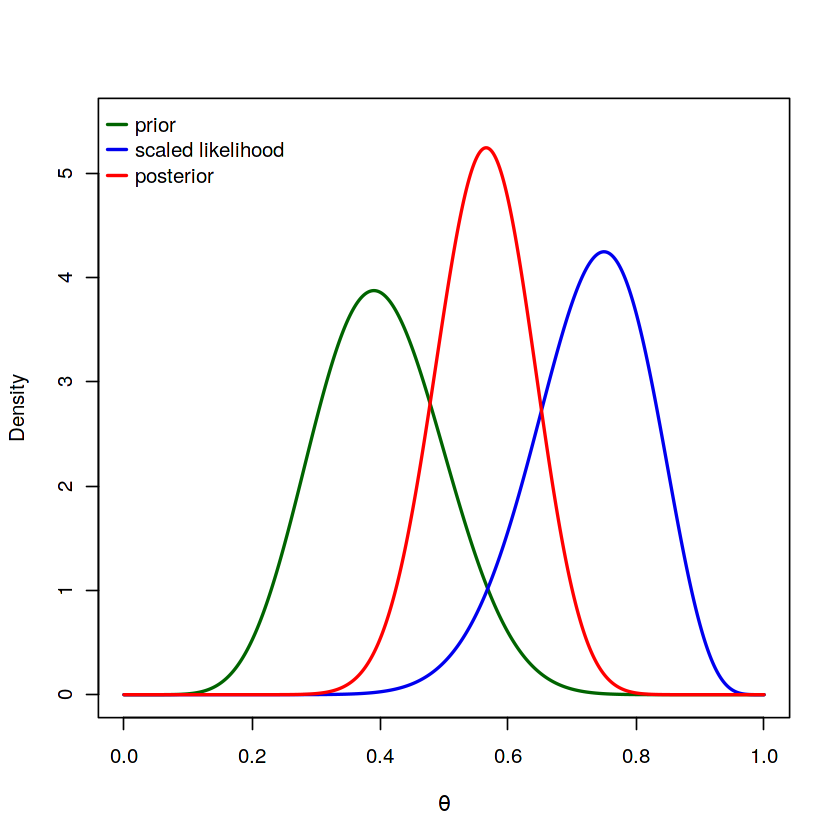

In [2]:
#Rescaled likelihood
theta=seq(0,1,len=500)
a=9.2; b=13.8; y=15; n=20
prior=dbeta(theta,a,b)
likelihood=dbinom(y,n,theta)
posterior=dbeta(theta,a+y,b+n-y)

f=function(x,size,prob){dbinom(x,size,prob)}
area=integrate(f,x=y,size=n,lower=0,upper=1)$value
const=1/area

plot(theta,prior,col="darkgreen",ylab="Density",xlab=expression(theta),type="l",ylim=c(0,5.5),lwd=2)
lines(theta,const*likelihood,col="blue2",lwd=2)
lines(theta,posterior,col="red",lwd=2)
legend("topleft",legend=c("prior","scaled likelihood","posterior"),lty=c(1,1,1),lwd=c(2,2,2),col=c("darkgreen","blue2","red"),bty="n")

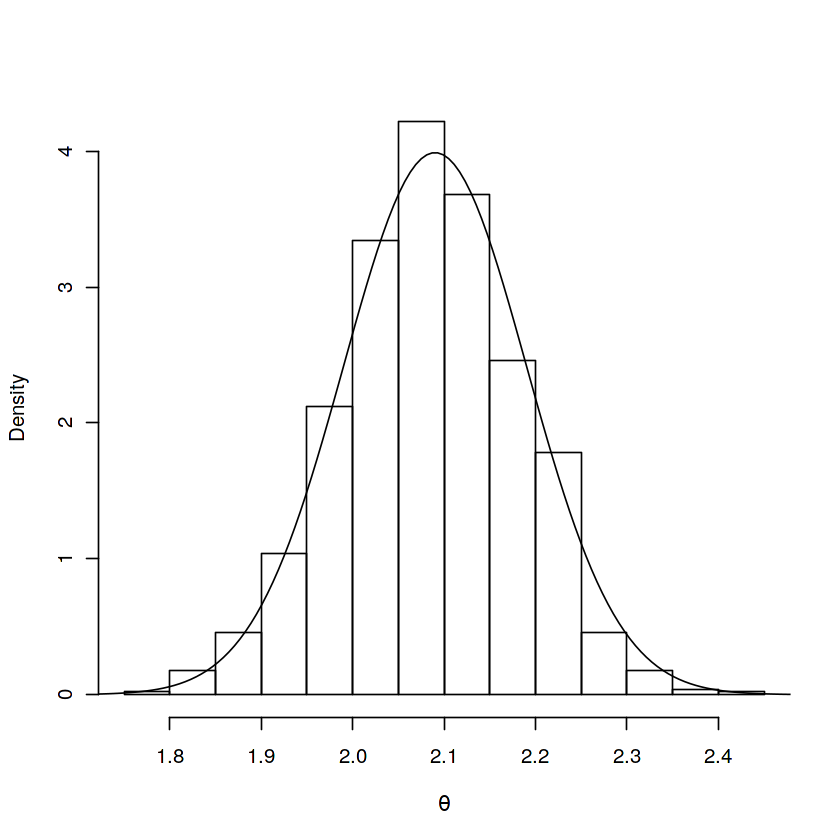

In [3]:
#Grid approximation example
#generate data
set.seed(123)
n=100; y=rnorm(n,2,1)

#true posterior distribution for theta
posterior=function(theta,data){
n=length(data)
thetam=((0/100)+(n*mean(data)/1))/((1/100)+n/1)
thetasd=sqrt(1/((1/100)+n/1))
post=dnorm(theta,mean=thetam,sd=thetasd)  
return(post)
}

#unnormalised posterior
unposterior=function(theta,data){
likelihood=prod(dnorm(data,theta,1))    
prior=dnorm(theta,0,10)  
unpost=likelihood*prior
return(unpost)
}

#the range of the data is -0.4 and 4.2, so the mean needs to be within this range, I will let it to be between -1 and 5
m=1000
thetagrid=seq(-1,5,len=m)

#evaluating unnormalised posterior at grid points
unnormal.post.ord=numeric(m)
for(i in 1:m){
unnormal.post.ord[i]=unposterior(theta=thetagrid[i],data=y) 
}
  
#sample grid values 
theta.f=sample(thetagrid,size=m,replace=TRUE,prob=unnormal.post.ord)

#draw histogram of the data versus true posterior density
hist(theta.f,freq=F,breaks=20,xlab=expression(theta),ylab="Density",main="")
lines(thetagrid,posterior(theta=thetagrid,data=y),type="l")


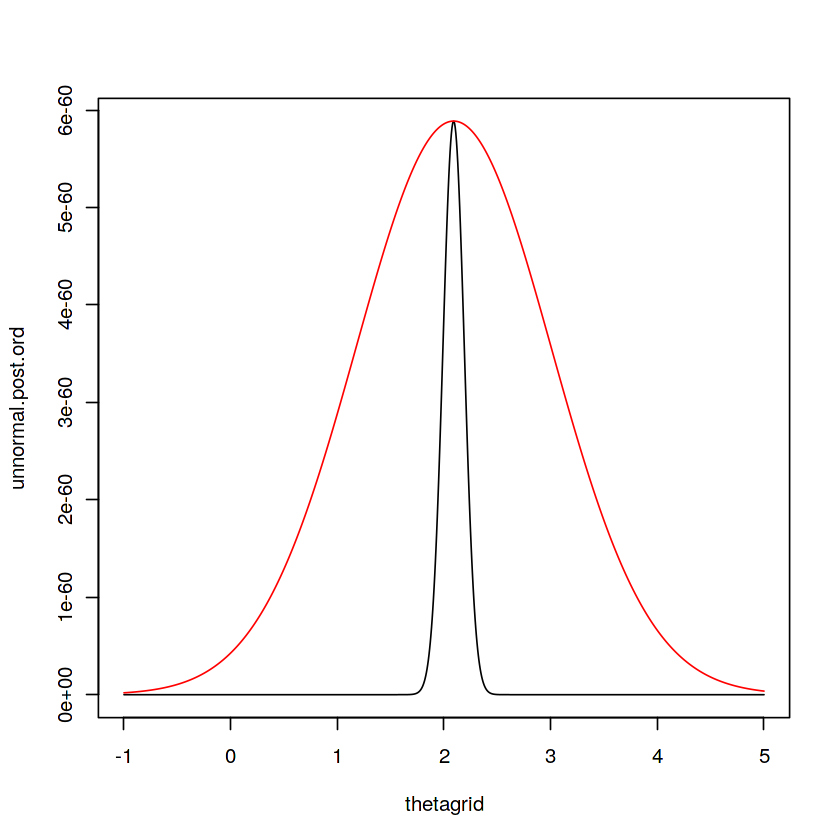

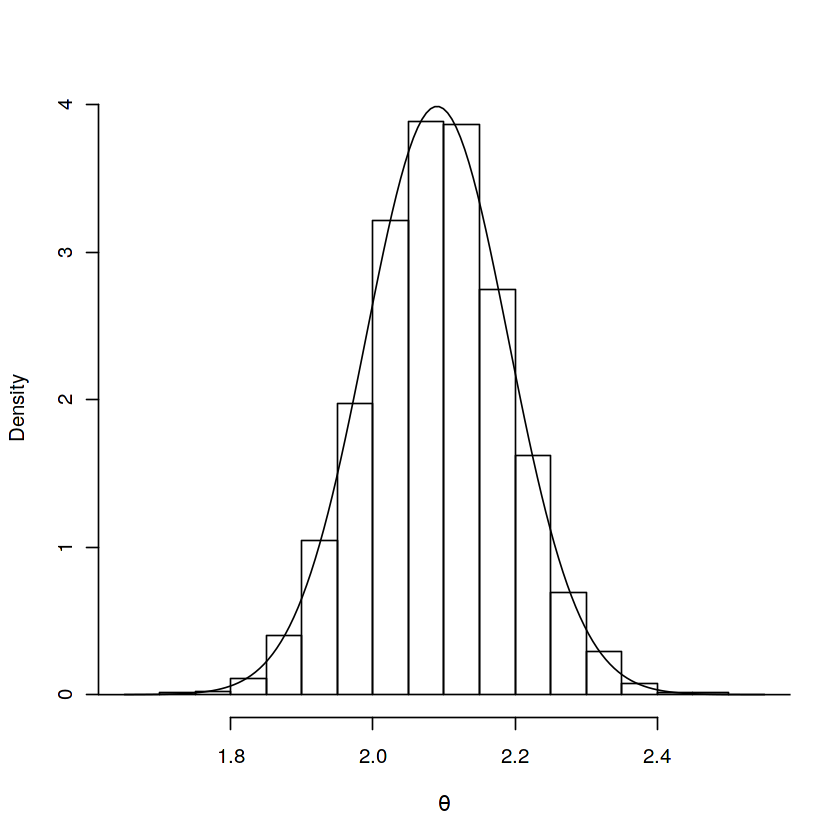

In [4]:
#Rejection sampling
#generate data
set.seed(123)
n=100; y=rnorm(n,2,1)

#true posterior distribution for theta
posterior=function(theta,data){
n=length(data)
thetam=((0/100)+(n*mean(data)/1))/((1/100)+n/1)
thetasd=sqrt(1/((1/100)+n/1))
post=dnorm(theta,mean=thetam,sd=thetasd)  
return(post)
}

#unnormalised posterior
unposterior=function(theta,data){
likelihood=prod(dnorm(data,theta,1))    
prior=dnorm(theta,0,10)  
unpost=likelihood*prior
return(unpost)
}

#proposal distribution
g=function(theta,m,s){
g=dnorm(theta,mean=m,sd=s)  
}

#auxiliar function to determine the optimal value of M; need to find maximum of unnormalised posterior/g 
aux=function(theta,data){
likelihood=prod(dnorm(data,theta,1))    
prior=dnorm(theta,0,10) 
post=likelihood*prior
g=dnorm(theta,mean=mean(data),sd=sd(data))    
aux=post/g
return(aux)
}

M=optimize(aux,interval=c(-1,5),data=y,maximum=TRUE)$objective

m=1000
thetagrid=seq(-1,5,len=m)
unnormal.post.ord=numeric(m)
for(i in 1:m){
unnormal.post.ord[i]=unposterior(theta=thetagrid[i],data=y) 
}

plot(thetagrid,unnormal.post.ord,type="l")
lines(thetagrid,M*g(thetagrid,m=mean(y),s=sd(y)),col="red")

#rejection sampling algorithm
n.samples=10000
count=0; attempts=0; thetapost=rep(0,n.samples)
while(count<n.samples){
attempts=attempts+1  
theta.c=rnorm(1,mean(y),sd(y))
u=runif(1,0,1)
alpha=unposterior(theta=theta.c,data=y)/(M*g(theta.c,mean(y),sd(y)))
if(u<=alpha){
count=count+1
thetapost[count]=theta.c
}
}

hist(thetapost,freq=F,breaks=20,xlab=expression(theta),ylab="Density",main="")
lines(thetagrid,posterior(theta=thetagrid,data=y))

Loading required package: pscl

Classes and Methods for R developed in the
Political Science Computational Laboratory
Department of Political Science
Stanford University
Simon Jackman
hurdle and zeroinfl functions by Achim Zeileis



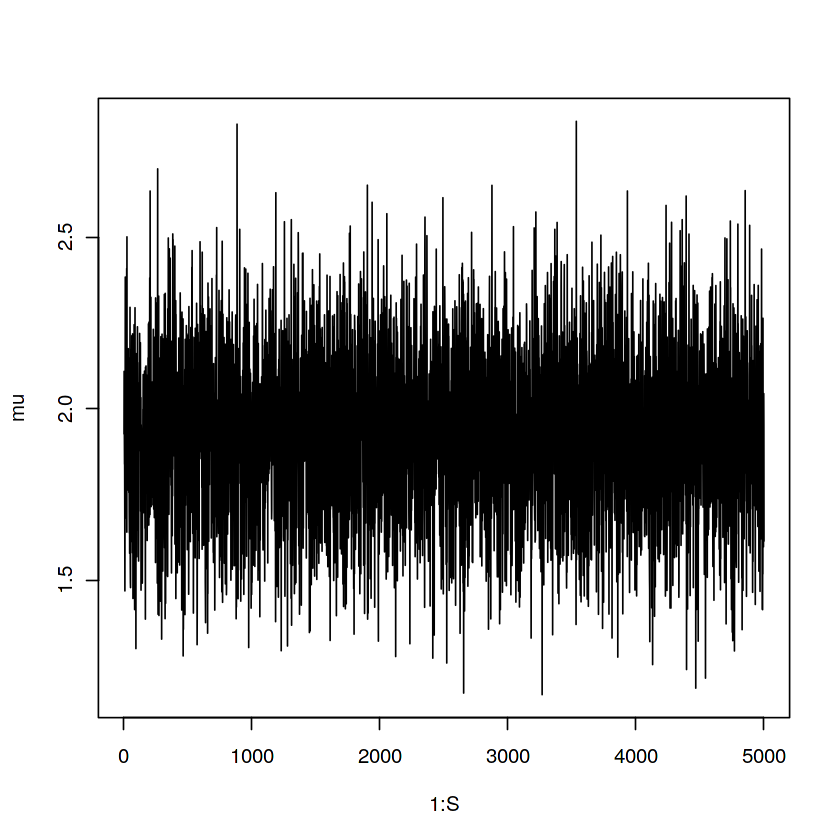

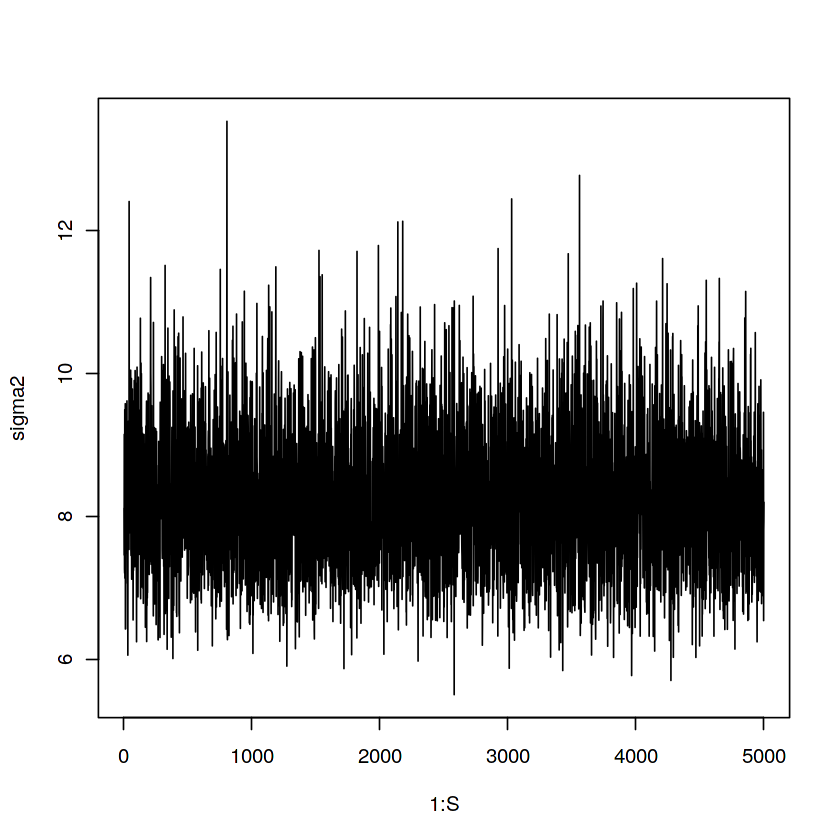

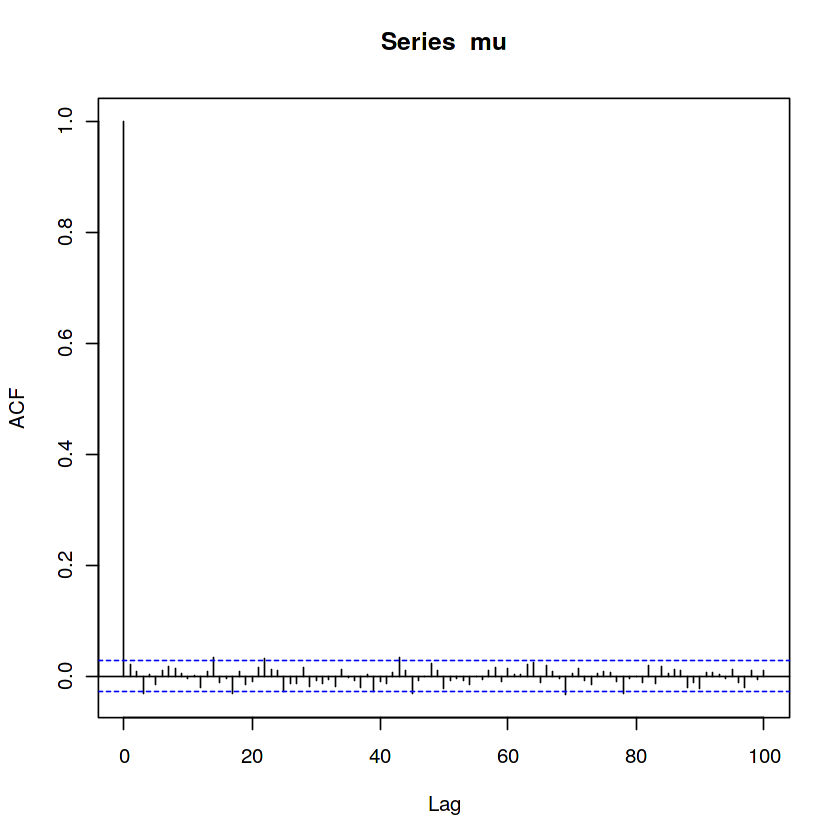

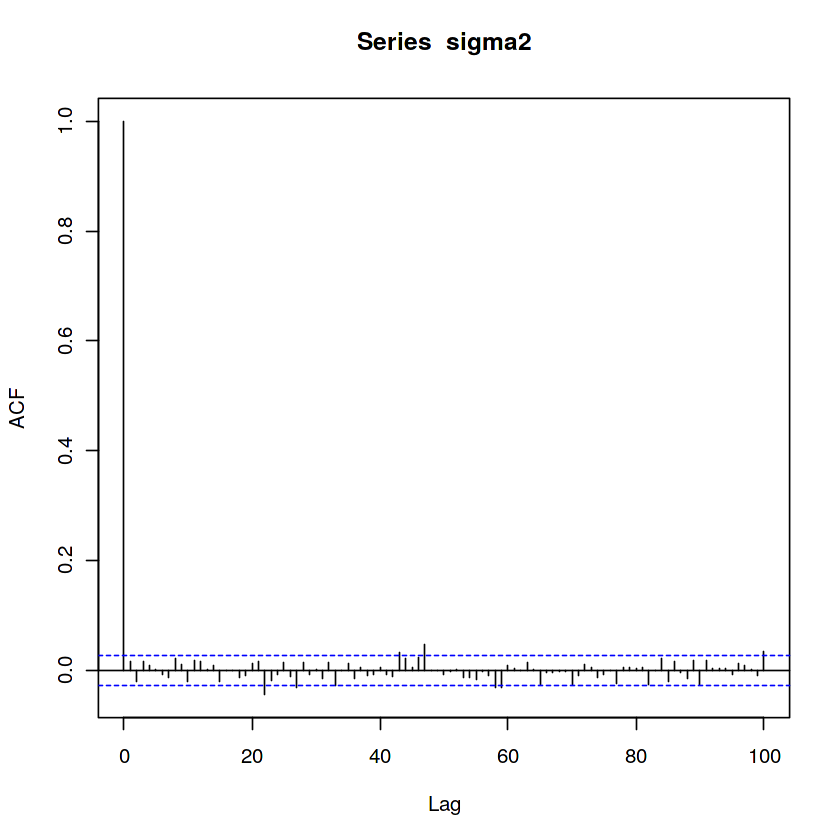

In [5]:
#Example Gibbs normal
require(pscl) #to simulate from the inverse gamma

#generate data
set.seed(123)
n=150; y=rnorm(n,2,3)

#number iterations
S=5000
mu=sigma2=numeric(S)

#prior specification
mu0=0; sigma02=100; a=b=0.1

#initial values
mu[1]=mean(y); sigma2[1]=var(y)
#mu[1]=rnorm(1,0,10); sigma2[1]=rigamma(1,a,b)

for(i in 2:S){
meanmu=((mu0/sigma02)+((n*mean(y))/(sigma2[i-1])))/((1/sigma02)+(n/sigma2[i-1]))
varmu=1/((1/sigma02)+(n/sigma2[i-1]))
#sampling mu
mu[i]=rnorm(1,meanmu,sqrt(varmu))

a1=a+(n/2)
b1=b+0.5*sum((y-mu[i])^2)
#sampling sigma2
sigma2[i]=rigamma(1,a1,b1)
}

#traceplots
plot(1:S,mu,type="l")
plot(1:S,sigma2,type="l")

#ACFs
acf(mu,lag.max=100)
acf(sigma2,lag.max=100)


In [ ]:
#Example: random walk Metropolis-Hastings
#generate data
set.seed(123)
n=150; sigma2=1; y=rnorm(n,4,sqrt(sigma2))

#prior specification
mu0=0; sigma20=100

#number iterations, store results, and initial value
S=10000; mu=numeric(S); mu[1]=rnorm(1,mu0,sqrt(sigma20))

count=0 #(number of candidates accepted)

#tunning parameter
s2=0.1 #(good acceptance rate)
#s2=0.001 #(very high acceptance rate)
#s2=2 #(very low acceptance rate)

#in the following, to avoid numerical instabilities we work on the log scale

for(i in 2:S){
  #generate candidate
  mustar=rnorm(1,mean=mu[i-1],sd=sqrt(s2))  
  
  #numerator of acceptance probability
  p1=sum(dnorm(y,mean=mustar,sd=sqrt(sigma2),log=TRUE))+dnorm(mustar,mean=mu0,sd=sqrt(sigma20),log=TRUE)
  
  #denominator of acceptance probability
  p2=sum(dnorm(y,mean=mu[i-1],sd=sqrt(sigma2),log=TRUE))+dnorm(mu[i-1],mean=mu0,sd=sqrt(sigma20),log=TRUE)
  
  u=runif(1)
  if(log(u)<min(0,p1-p2)){
    mu[i]=mustar; count=count+1  
  }
  else{mu[i]=mu[i-1]
  }
}

nburn=500
100*(count/S); mean(mu[(nburn+1):S])
plot(1:S,mu,type="l"); acf(mu,lag.max=500)
